In [1]:
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2020-03-03 09:38:48--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M   678KB/s    in 17s     

2020-03-03 09:39:06 (333 KB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [1]:
import pandas as pd
import torch as torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
import time
import numpy as np
from sklearn.manifold import TSNE

import math
from torch.utils.data import Dataset
import itertools
import seaborn as sns
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tabulate import tabulate
from elasticsearch import Elasticsearch, helpers

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
movies_df = pd.read_csv('ml-1m/movies.dat', sep='::',
                     names=['movieId','title','genres'],
                     encoding='latin-1',engine='python')
movies_df['movieId_index'] = movies_df['movieId'].astype('category').cat.codes

In [4]:
movies_df.head(4)

,movieId,title,genres,movieId_index
0,1,Toy Story (1995),Animation|Children's|Comedy,0
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama,3


In [5]:
users_df = pd.read_csv('ml-1m/users.dat',sep='::',
                       header=None,
                       names=['userId', 'gender' ,'age','occupation', 'zipcode'],
                       engine='python')
users_df['gender_index'] = users_df['gender'].astype('category').cat.codes
users_df['age_index'] = users_df['age'].astype('category').cat.codes
users_df['occupation_index'] = users_df['occupation'].astype('category').cat.codes
users_df['userId_index'] = users_df['userId'].astype('category').cat.codes

In [6]:
users_df.head(5)

,userId,gender,age,occupation,zipcode,gender_index,age_index,occupation_index,userId_index
0,1,F,1,10,48067,0,0,10,0
1,2,M,56,16,70072,1,6,16,1
2,3,M,25,15,55117,1,2,15,2
3,4,M,45,7,02460,1,4,7,3
4,5,M,25,20,55455,1,2,20,4


In [7]:
ratings=pd.read_csv('ml-1m/ratings.dat',sep='::',
                    names=['userId','movieId','rating','time'],engine='python')
ratings=ratings.join(movies_df.set_index('movieId'),on='movieId')
ratings=ratings.join(users_df.set_index('userId'), on='userId')

In [8]:
ratings.head(4)

,userId,movieId,rating,time,title,genres,movieId_index,gender,age,occupation,zipcode,gender_index,age_index,occupation_index,userId_index
0,1,1193,5,978300760,One Flew Over the Cuckoo's Nest (1975),Drama,1176,F,1,10,48067,0,0,10,0
1,1,661,3,978302109,James and the Giant Peach (1996),Animation|Children's|Musical,655,F,1,10,48067,0,0,10,0
2,1,914,3,978301968,My Fair Lady (1964),Musical|Romance,902,F,1,10,48067,0,0,10,0
3,1,3408,4,978300275,Erin Brockovich (2000),Drama,3339,F,1,10,48067,0,0,10,0


In [9]:
feature_columns = ['userId_index','movieId_index','age_index','gender_index','occupation_index']

In [10]:
# This is the width of each feature (number of values)
features_sizes = {
    'userId_index':len(ratings['userId_index'].unique()),
    'movieId_index':len(ratings['movieId_index'].unique()),
    'age_index':len(ratings['age_index'].unique()),
    'gender_index':len(ratings['gender_index'].unique()),
    'occupation_index':len(ratings['occupation_index'].unique()),
}

# calculate offsets.
# Each feature starts from the end of the last one.

next_offset = 0
features_offsets={}
for k,v in features_sizes.items():
    features_offsets[k] = next_offset
    next_offset += v

In [11]:
# map all column indices to start from correct offset
for column in feature_columns:
    ratings[column] = ratings[column].apply(lambda c: c + features_offsets[column])   

In [12]:
#print(tabulate(ratings[[*feature_columns,'rating']].head(4),headers=ratings[[*feature_columns,'rating']].columns,tablefmt="github"))
ratings[[*feature_columns,'rating']].head(5)

,userId_index,movieId_index,age_index,gender_index,occupation_index,rating
0,0,7216,9746,9753,9765,5
1,0,6695,9746,9753,9765,3
2,0,6942,9746,9753,9765,3
3,0,9379,9746,9753,9765,4
4,0,8326,9746,9753,9765,5


In [13]:
data_x = torch.tensor(ratings[feature_columns].values)
data_y = torch.tensor(ratings['rating'].values).float()
dataset = data.TensorDataset(data_x, data_y)

In [14]:
bs=1024
train_n = int(len(dataset)*0.9)
valid_n = len(dataset) - train_n
splits = [train_n,valid_n]
assert sum(splits) == len(dataset)
trainset,devset = torch.utils.data.random_split(dataset,splits)
train_dataloader = data.DataLoader(trainset,batch_size=bs,shuffle=True)
dev_dataloader = data.DataLoader(devset,batch_size=bs,shuffle=True)

In [15]:
# copied from fastai: 
def trunc_normal_(x, mean=0., std=1.):
    "Truncated normal initialization."
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

In [16]:
class FMModel(nn.Module):
    def __init__(self, n, k):
        super().__init__()

        self.w0 = nn.Parameter(torch.zeros(1))
        self.bias = nn.Embedding(n, 1)
        self.embeddings = nn.Embedding(n, k)

        # See https://arxiv.org/abs/1711.09160
        with torch.no_grad(): trunc_normal_(self.embeddings.weight, std=0.01)
        with torch.no_grad(): trunc_normal_(self.bias.weight, std=0.01)

    def forward(self, X):
        emb = self.embeddings(X)
        # calculate the interactions in complexity of O(nk) see lemma 3.1 from paper
        pow_of_sum = emb.sum(dim=1).pow(2)
        sum_of_pow = emb.pow(2).sum(dim=1)
        pairwise = (pow_of_sum-sum_of_pow).sum(1)*0.5
        bias = self.bias(X).squeeze().sum(1)
        return torch.sigmoid(self.w0 + bias + pairwise)*5.5

In [17]:
# fit/test functions
def fit(iterator, model, optimizer, criterion):
    train_loss = 0
    model.train()
    for x,y in iterator:
        optimizer.zero_grad()
        y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss += loss.item()*x.shape[0]
        loss.backward()
        optimizer.step()
    return train_loss / len(iterator.dataset)

def test(iterator, model, criterion):
    train_loss = 0
    model.eval()
    for x,y in iterator:                    
        with torch.no_grad():
            y_hat = model(x.to(device))
        loss = criterion(y_hat, y.to(device))
        train_loss += loss.item()*x.shape[0]
    return train_loss / len(iterator.dataset)

In [18]:
def train_n_epochs(model, n, optimizer,scheduler):
    criterion = nn.MSELoss().to(device)
    for epoch in range(n):
        start_time = time.time()
        train_loss = fit(train_dataloader, model, optimizer, criterion)
        valid_loss = test(dev_dataloader, model, criterion)
        scheduler.step()
        secs = int(time.time() - start_time)
        print(f'epoch {epoch}. time: {secs}[s]')
        print(f'\ttrain rmse: {(math.sqrt(train_loss)):.4f}')
        print(f'\tvalidation rmse: {(math.sqrt(valid_loss)):.4f}')


In [19]:
model = FMModel(data_x.max()+1, 120).to(device)
wd=1e-5
lr=0.001
epochs=10
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[7], gamma=0.1)
criterion = nn.MSELoss().to(device)
for epoch in range(epochs):
    start_time = time.time()
    train_loss = fit(train_dataloader, model, optimizer, criterion)
    valid_loss = test(dev_dataloader, model, criterion)
    scheduler.step()
    secs = int(time.time() - start_time)
    print(f'epoch {epoch}. time: {secs}[s]')
    print(f'\ttrain rmse: {(math.sqrt(train_loss)):.4f}')
    print(f'\tvalidation rmse: {(math.sqrt(valid_loss)):.4f}')

epoch 0. time: 49[s]
	train rmse: 0.9427
	validation rmse: 0.9116
epoch 1. time: 50[s]
	train rmse: 0.8991
	validation rmse: 0.8967
epoch 2. time: 50[s]
	train rmse: 0.8766
	validation rmse: 0.8816
epoch 3. time: 55[s]
	train rmse: 0.8525
	validation rmse: 0.8710
epoch 4. time: 54[s]
	train rmse: 0.8288
	validation rmse: 0.8648
epoch 5. time: 54[s]
	train rmse: 0.8037
	validation rmse: 0.8603
epoch 6. time: 52[s]
	train rmse: 0.7765
	validation rmse: 0.8572
epoch 7. time: 50[s]
	train rmse: 0.7326
	validation rmse: 0.8540
epoch 8. time: 50[s]
	train rmse: 0.7268
	validation rmse: 0.8535
epoch 9. time: 54[s]
	train rmse: 0.7224
	validation rmse: 0.8535


## Understand Embeddings

In [54]:
movies = ratings.drop_duplicates('movieId_index').copy()
movie_embeddings = model.embeddings(torch.tensor(movies['movieId_index'].values,device=device).long())
movies['embedding'] = movie_embeddings.tolist()
movie_biases = model.bias(torch.tensor(movies['movieId_index'].values,device=device).long())
movies['bias'] = movie_biases.cpu().detach().numpy()

In [21]:
movies[['title','movieId_index','embedding','bias']]

,title,movieId_index,embedding,bias
0,One Flew Over the Cuckoo's Nest (1975),7216,"[0.28399068117141724, 0.27064165472984314, 0.3...",0.296528
1,James and the Giant Peach (1996),6695,"[0.147650808095932, 0.043052155524492264, 0.05...",-0.052868
2,My Fair Lady (1964),6942,"[0.17243516445159912, -0.05406080558896065, 0....",0.093793
3,Erin Brockovich (2000),9379,"[0.07425906509160995, -0.08210873603820801, 0....",0.204388
4,"Bug's Life, A (1998)",8326,"[-0.0025251160841435194, -0.27461206912994385,...",0.133541
...,...,...,...,...
919876,Modulations (1998),8169,"[0.021013814955949783, -0.017801446840167046, ...",0.089735
940262,Broken Vessels (1998),8674,"[-0.008717681281268597, -0.0037067122757434845...",-0.060727
957826,White Boys (1999),8816,"[-0.06269466131925583, 0.011752610094845295, 0...",-0.133646
970914,One Little Indian (1973),9578,"[0.023901021108031273, -0.0074755046516656876,...",0.091031


In [22]:
movies_subset = movies[movies['genres'].str.contains('Children\'s|Horror|Documentary')].copy()
X = np.stack(movies_subset['embedding'].values)
ldr = TSNE(n_components=2, random_state=0)
Y = ldr.fit_transform(X)
movies_subset['x'] = Y[:, 0]
movies_subset['y'] = Y[:, 1]

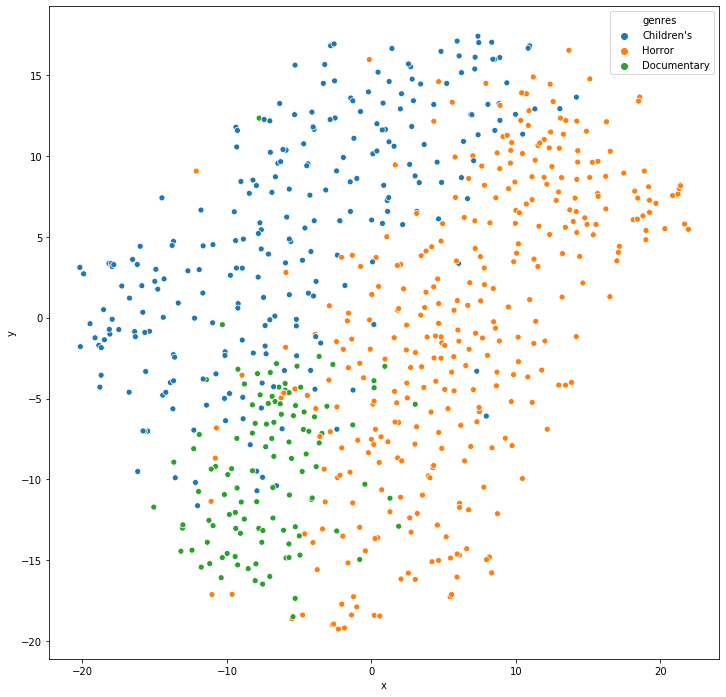

In [23]:
def single_genre(g):
    for i in ['Children\'s', 'Horror', 'Documentary']:
        if i in g: return i
        
movies_subset['genres']=movies_subset['genres'].apply(single_genre)
plt.figure(figsize=(12, 12))
ax = sns.scatterplot(x="x", y="y", hue='genres',data=movies_subset)
plt.savefig('movie_emb.png', bbox_inches='tight')

In [24]:
star_wars_5_index=torch.tensor(6297,device=device) 	
star_war_embeddings = model.embeddings(star_wars_5_index)
cosine_similarities = torch.tensor([F.cosine_similarity(star_war_embeddings,i,dim=0) for i in movie_embeddings])
movies.iloc[cosine_similarities.argsort(descending=True).detach().numpy()]['title'].values[:10]

array(['Star Wars: Episode IV - A New Hope (1977)',
       'Star Wars: Episode V - The Empire Strikes Back (1980)',
       'Star Wars: Episode VI - Return of the Jedi (1983)',
       'Raiders of the Lost Ark (1981)',
       'Indiana Jones and the Last Crusade (1989)', 'Ghostbusters (1984)',
       'Batman (1989)',
       'Star Wars: Episode I - The Phantom Menace (1999)',
       'Sting, The (1973)', 'Secret Agent (1936)'], dtype=object)

In [53]:
toy_story_index=torch.tensor(6040,device=device)
toy_story_embeddings = model.embeddings(toy_story_index)
cosine_similarities = torch.tensor([F.cosine_similarity(toy_story_embeddings,i,dim=0) 
                                    for i in movie_embeddings])
[i for i in movies.iloc[cosine_similarities.argsort(descending=True).detach().numpy()]['title'].values[:10]]

['Toy Story (1995)',
 'Toy Story 2 (1999)',
 "Bug's Life, A (1998)",
 'Beauty and the Beast (1991)',
 'Aladdin (1992)',
 'Little Mermaid, The (1989)',
 'Babe (1995)',
 'Lion King, The (1994)',
 'Tarzan (1999)',
 'Back to the Future (1985)']

## Recommending

In [50]:
man_embedding = model.embeddings(torch.tensor(9754,device=device))
age18_25_embedding = model.embeddings(torch.tensor(9747,device=device))
metadata_embedding = man_embedding+age18_25_embedding
rankings = movie_biases.squeeze()+(metadata_embedding*movie_embeddings).sum(1)
[i for i in movies.iloc[rankings.argsort(descending=True).cpu()]['title'].values][:10]

['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'American Beauty (1999)',
 'Godfather, The (1972)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Braveheart (1995)',
 'Sanjuro (1962)',
 'Monty Python and the Holy Grail (1974)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)']

In [52]:
woman_embedding = model.embeddings(torch.tensor(9753,device=device))
age50_56_embedding = model.embeddings(torch.tensor(9751,device=device))
metadata_embedding = woman_embedding+age50_56_embedding
rankings = movie_biases.squeeze()+(metadata_embedding*movie_embeddings).sum(1)
[i for i in movies.iloc[rankings.argsort(descending=True).cpu()]['title'].values][:10]

['To Kill a Mockingbird (1962)',
 'Wrong Trousers, The (1993)',
 'African Queen, The (1951)',
 'Close Shave, A (1995)',
 "Schindler's List (1993)",
 'Man for All Seasons, A (1966)',
 'Some Like It Hot (1959)',
 'General, The (1927)',
 'Sound of Music, The (1965)',
 'Wizard of Oz, The (1939)']

## Elasticsearch


In [32]:
es = Elasticsearch()

In [34]:
def generate_movie_docs():
    for i, movie in movies.iterrows():
        yield {
            '_index': 'recsys',
            '_id': f'movie_{movie["movieId"]}',
            '_source': {'embedding':movie['embedding'],
                    'bias':movie['bias'],
                    'feature_type':'movie',
                    'title':movie['title']
                   }
        }
helpers.bulk(es,generate_movie_docs())

(3706, [])

In [35]:
users = ratings.drop_duplicates('userId_index').copy()
users['embedding'] = model.embeddings(torch.tensor(users['userId_index'].values,device=device)).tolist()
users['bias'] = model.bias(torch.tensor(users['userId_index'].values,device=device)).detach().numpy()

def generate_user_docs():
    for i, user in users.iterrows():
        yield {
            '_index': 'recsys',
            '_id': f'user_{user["userId"]}',
            '_source': {'embedding':user['embedding'],
                    'bias':user['bias'],
                    'feature_type':'user',
                   }
        }
helpers.bulk(es,generate_user_docs())

(6040, [])

In [36]:
ages = [i+features_offsets['age_index'] for i in range(features_sizes['age_index'])]
def generate_age_docs():
    for age_index in ages:
        yield {
            '_index': 'recsys',
            '_id': f'age_{age_index}',
            '_source': {'embedding':model.embeddings(torch.tensor(age_index,device=device)).tolist(),
                    'bias':model.bias(torch.tensor(age_index,device=device)).item(),
                    'feature_type':'age',
                   }
        }
helpers.bulk(es,generate_age_docs())

(7, [])

In [37]:
genders = [i+features_offsets['gender_index'] for i in range(features_sizes['gender_index'])]
def generate_gender_docs():
    for gender_index in genders:
        yield {
            '_index': 'recsys',
            '_id': f'gender_{gender_index}',
            '_source': {'embedding':model.embeddings(torch.tensor(gender_index,device=device)).tolist(),
                    'bias':model.bias(torch.tensor(gender_index,device=device)).item(),
                    'feature_type':'gender',
                   }
        }
helpers.bulk(es,generate_gender_docs())

(2, [])

In [38]:
occupations = [i+features_offsets['occupation_index'] for i in range(features_sizes['occupation_index'])]
def generate_occupation_docs():
    for occupation_index in occupations:
        yield {
            '_index': 'recsys',
            '_id': f'occupation_{occupation_index}',
            '_source': {'embedding':model.embeddings(torch.tensor(occupation_index,device=device)).tolist(),
                    'bias':model.bias(torch.tensor(occupation_index,device=device)).item(),
                    'feature_type':'occupation',
                   }
        }
helpers.bulk(es,generate_occupation_docs())

(21, [])

In [39]:
metadata = es.mget({"docs":[
    {
        "_index" : "recsys",
        "_id" : "age_9747"},
    {
        "_index" : "recsys",
        "_id" : "gender_9754"}]})
embeddings = [doc['_source']['embedding'] for doc in metadata['docs']]
v_metadata = [sum(pair) for pair in zip(*embeddings)]


In [41]:
search_body = {
    "query": {
    "script_score": {
      "query" : {
          "bool" : {
          "filter" : {
            "term" : {
              "feature_type" : "movie" 
            }
          }
        }
      },
      "script": {
        "source": "dotProduct(params.query_vector, \u0027embedding\u0027) + doc[\u0027bias\u0027].value", 
        "params": {
          "query_vector": v_metadata
        }
      }
    }
  }
}
[hit['_source']['title'] 
 for hit in es.search(search_body,index='recsys',_source_includes='title')['hits']['hits']]


['Shawshank Redemption, The (1994)',
 'Usual Suspects, The (1995)',
 'American Beauty (1999)',
 'Godfather, The (1972)',
 'Life Is Beautiful (La Vita è bella) (1997)',
 'Braveheart (1995)',
 'Sanjuro (1962)',
 'Monty Python and the Holy Grail (1974)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)']